In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_style('white')
np.random.seed(42)

from scipy.stats import ttest_rel
from scipy.stats import combine_pvalues

from gpu_utils import restrict_GPU_pytorch
from fig_helpers import add_metrics_to_df, adjust_box_widths
from paths import FIG_DIR
restrict_GPU_pytorch('0')

# Options are auc or auprc. This metric is used to determine early stopping.
val_loss_key = 'auc'

orig = sns.color_palette('colorblind')
method_colors = [orig[2], orig[0], orig[1], orig[3], orig[4]]
method_colors = ['#4daf4a', '#e41a1c', '#377eb8', '#ff7f00', '#984ea3']
hue_order = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
plotted_methods = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
method_name_dict = {"supervised": "Supervised", "negative": "Negative", "scar-c": "SCAR-C",
                    'scar-km2': 'KM2', "sar-em": "EM", "ours": "PURPLE"}

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Using GPU:0


In [3]:
import torch

from sarpu.pu_learning import *
from eval_fs import eval_relative_prior
from method import train_relative_estimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from simulation_helpers import create_gap_1d, create_gap_nd
from simulation_helpers import generate_g, generate_y, generate_s_scar
from simulation_helpers import separable_decision_rule_1d, inseparable_decision_rule_1d
from simulation_helpers import separable_decision_rule_nd, inseparable_decision_rule_nd

from method import train_relative_estimator, get_loss
from baselines import cdmm, supervised_rel_prior, sar_em_rel_prior, scar_km2_rel_prior

### Generating data for each group.

Parameters that you can plan with are $c_1$, $c_2$, group_gap, and separability assumption ('separable', 'overlap', 'overlaid'). In addition, you can change std, the standard deviation of the Gaussian distributions for each group, n_to_sample, and n_attributes.

In [4]:
# Parameter settings
c1 = .5
c2 = .3
n_groups = 2
group_gap = -2
scar_assumption = True
separability_assumption = 'overlap'
std, n_to_sample, n_attributes = 16, 10000, 5
n_epochs = 10000

n_to_sample_g1 = n_to_sample
n_to_sample_g2 = 2*n_to_sample

g1_mean = np.ones(n_attributes)
g2_mean =  g1_mean + group_gap
g1_config = {'mean': g1_mean, 'std': std, 'n_samples': n_to_sample_g1, 
             'n_attributes': n_attributes, 'n_groups': n_groups, 'group_feat': 1, 'n_epochs':n_epochs,
                 'group1_idx': 0}
g1_config['lamda'] = 0
g2_config = {'mean': g2_mean, 'std': std, 'n_samples': n_to_sample_g2, 
             'n_attributes': n_attributes, 'n_groups': n_groups, 'group_feat': 2, 
             'group1_idx': 0}

expmt_config = {'scar_assumption': scar_assumption, 
                'separability_assumption': separability_assumption, 
                'labeling_frequency_g1': c1, 'labeling_frequency_g2': c2, 
                 'group1_idx': 0} 

In [5]:
x1 = generate_g(g1_config)
x2 = generate_g(g2_config)

if expmt_config['separability_assumption'] == 'separable':
    y1 = generate_y(x1, g1_config, separable_decision_rule_nd)
    y2 = generate_y(x2, g2_config, separable_decision_rule_nd)
    x1, y1 = create_gap_nd(x1, y1, g1_config)
    x2, y2 = create_gap_nd(x2, y2, g2_config)
elif expmt_config['separability_assumption'] == 'overlap':
    y1 = generate_y(x1, g1_config, inseparable_decision_rule_nd, beta=1)
    y2 = generate_y(x2, g2_config, inseparable_decision_rule_nd, beta=1)
elif expmt_config['separability_assumption'] == 'overlaid':
    beta = 1
    y1 = generate_y(x1, g1_config, inseparable_decision_rule_nd, beta=.75, scale=.75)
    y2 = generate_y(x2, g2_config, inseparable_decision_rule_nd, beta=.75, scale=.75)

# generate observed labels
if expmt_config['scar_assumption']:
    s1 = generate_s_scar(y1, expmt_config['labeling_frequency_g1'])
    s2 = generate_s_scar(y2, expmt_config['labeling_frequency_g2'])


# split into train, val, test
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
s = np.concatenate([s1, s2])

### Splitting  x, y, and s into train and test sets.

In [6]:
x1_train, x1_test, y1_train, y1_test, s1_train, s1_test = train_test_split(x1, y1, s1, test_size=.2, 
                                                                                  random_state=10, shuffle=True)
x2_train, x2_test, y2_train, y2_test, s2_train, s2_test = train_test_split(x2, y2, s2, test_size=.2, 
                                                                                  random_state=10, shuffle=True)

x_train = np.concatenate([x1_train, x2_train])
y_train = np.concatenate([y1_train, y2_train])
s_train = np.concatenate([s1_train, s2_train])

x_test = np.concatenate([x1_test, x2_test])
y_test = np.concatenate([y1_test, y2_test])
s_test = np.concatenate([s1_test, s2_test])

scale_factor = np.max(np.abs(x_train))
x_train_norm = x_train/scale_factor
x_test_norm = x_test/scale_factor

g1_train_idxs = x_train[:,0] == 1
g2_train_idxs = x_train[:,1] == 1
g1_test_idxs = x_test[:,0] == 1
g2_test_idxs = x_test[:,1] == 1
classification_attributes = [i + n_groups for i in range(n_attributes)]

### Quick summary of the group statistics:

In [7]:
print("--- Group-specific p(y=1) --- ")
print("p( y = 1 | g = 1 )", np.mean(y1))
print("p( y = 1 | g = 2 )", np.mean(y2))

print("--- Group-specific p(s=1) --- ")
print("p( s = 1 | g = 1 )", np.mean(s1))
print("p( s = 1 | g = 2 )", np.mean(s2))

print("--- Number of Samples ---")
print(len(x))

--- Group-specific p(y=1) --- 
p( y = 1 | g = 1 ) 0.6554
p( y = 1 | g = 2 ) 0.34415
--- Group-specific p(s=1) --- 
p( s = 1 | g = 1 ) 0.3277
p( s = 1 | g = 2 ) 0.1032
--- Number of Samples ---
30000


## Train PURPLE

100%|██████████| 1000/1000 [00:04<00:00, 216.33it/s]


/local/divyas/invisible_conditions/relative_prevalence_benchmark/model_ckpts/c6b6d1596eb060792d78e7c552a02790model_final_1000
0.7851467221924906 0.41891466482399675


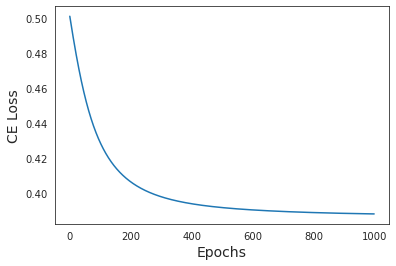

In [8]:
# Set regularization parameter
g1_config['estimator_type'] = 'logreg'
g1_config['optimizer'] = 'Adam'
g1_config['group_weights'] = (1, 1)
g1_config['n_epochs'] = 1000
g1_config['n_batches'] = 1

f_model, losses, info = train_relative_estimator(x_train, s_train, x_test, s_test, g1_config, save_model=True)
# pred_rel_prior, pred_g1_prior, pred_g2_prior = eval_relative_prior(x_test, f_model)
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("CE Loss")
print(info['auc'], info['auprc'])

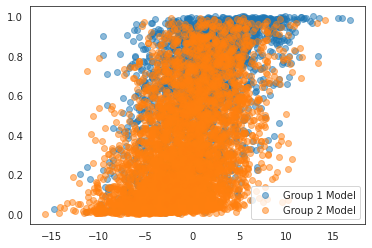

In [9]:
# Visual check to see if the same decision rule is learned for both group 1 & group 2
y1_test_pred = f_model.estimate_p_y(torch.Tensor(x_test[g1_test_idxs,2:]).cuda()).detach().cpu().numpy().squeeze()
y2_test_pred = f_model.estimate_p_y(torch.Tensor(x_test[g2_test_idxs,2:]).cuda()).detach().cpu().numpy().squeeze()
plt.scatter(x_test[g1_test_idxs,2], y1_test_pred,  alpha=.5, label='Group 1 Model')
plt.scatter(x_test[g2_test_idxs,2], y2_test_pred, alpha=.5, label='Group 2 Model')
plt.legend()

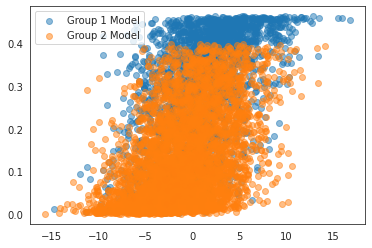

In [10]:
# Plot p(s|x)
s1_test_pred = f_model(torch.Tensor(x_test[g1_test_idxs]).cuda()).detach().cpu().numpy().squeeze()
s2_test_pred = f_model(torch.Tensor(x_test[g2_test_idxs]).cuda()).detach().cpu().numpy().squeeze()

plt.scatter(x_test[g1_test_idxs,2], s1_test_pred,  alpha=.5, label='Group 1 Model')
plt.scatter(x_test[g2_test_idxs,2],s2_test_pred, alpha=.5, label='Group 2 Model')
plt.legend()

In [13]:
true_g1_prior = y_test[g1_test_idxs].mean()
true_g2_prior = y_test[g2_test_idxs].mean()
pred_g1_prior = np.mean(y1_test_pred)
pred_g2_prior = np.mean(y2_test_pred)
print("Pred G1 Prior: ", pred_g1_prior, "Pred G2 Prior: ", pred_g2_prior)
print("True G1 Prior: ", true_g1_prior, "True G2 Prior: ", true_g2_prior)
print("True Relative Prior: ", true_g1_prior/true_g2_prior)
print("Pred Relative Prior: ", pred_g1_prior/pred_g2_prior)

Pred G1 Prior:  0.6420869 Pred G2 Prior:  0.33326322
True G1 Prior:  0.6525 True G2 Prior:  0.3485
True Relative Prior:  1.872309899569584
Pred Relative Prior:  1.926666


## Train baseline

In [14]:
# Change method here to play with a different baseline
method = 'negative'
if method == 'supervised':
    results = supervised_rel_prior(x_train[g1_train_idxs], 
                                   x_train[g2_train_idxs],
                                   y1_train, y2_train, x_test, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

elif method == 'negative':
    results = supervised_rel_prior(x_train[g1_train_idxs], 
                                   x_train[g2_train_idxs],
                                   s_train[g1_train_idxs],
                                   s_train[g2_train_idxs], x_test, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

elif method == 'sar-em':
    results = sar_em_rel_prior(x_train_norm[g1_train_idxs],
                               x_train_norm[g2_train_idxs],
                               s_train[g1_train_idxs],
                               s_train[g2_train_idxs], x_test_norm, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior,  models = results
    f1_model, f2_model = models
    
elif method == 'cdmm':
    results  = cdmm(x_train_norm[g1_train_idxs], x_train_norm[g2_train_idxs],
                s_train[g1_train_idxs], s_train[g2_train_idxs], g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models
    
elif method == 'scar-km2':
    results = scar_km2_rel_prior(x1_train, x2_train, s1_train, s2_train)
    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

Text(0.5, 0, 'Signed distance from hyperplane')

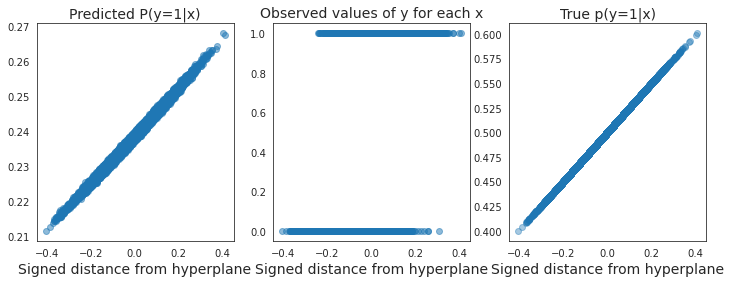

In [15]:
# Visualize predictions on training data
n_dims = g1_config['n_attributes']
y_pred = f1_model.model.predict_proba(x_train_norm[:,2:])[:,1]
ortho_normal = np.expand_dims(1*np.ones(n_attributes), 0)
features_train = np.dot(ortho_normal, x_train_norm[:,2:].T)
normalization = np.dot(ortho_normal, ortho_normal.T)[0][0]
features_train = features_train/normalization
y_true = (1/(1 + np.exp(-features_train*1)))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(features_train[0], y_pred, label='pred', alpha=.5)
axs[0].set_title("Predicted P(y=1|x)")
axs[0].set_xlabel("Signed distance from hyperplane")

axs[1].scatter(features_train[0], y_train, label='true', alpha=.5)
axs[1].set_title("Observed values of y for each x")
axs[1].set_xlabel("Signed distance from hyperplane")

axs[2].scatter(features_train[0], y_true, label='p(y)', alpha=.4)
axs[2].set_title("True p(y=1|x)")
axs[2].set_xlabel("Signed distance from hyperplane")

(1, 6000) (6000,)


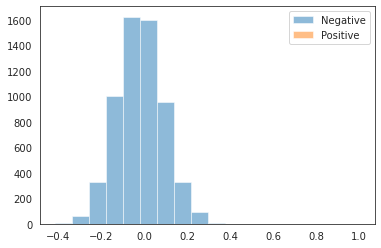

In [16]:
# Visualize predictions on test data 
y_pred = f1_model.predict_proba(x_test_norm)
ortho_normal = np.expand_dims(1*np.ones(n_attributes), 0)
features_test = np.dot(ortho_normal, x_test_norm[:,2:].T)
normalization = np.dot(ortho_normal, ortho_normal.T)[0][0]
features_test = features_test/normalization
binarized_y_pred = (y_pred > .5).astype(int)
print(features_test.shape, y_pred.shape)
plt.hist(features_test[0, binarized_y_pred == 0], alpha=.5, label='Negative')
plt.hist(features_test[0, binarized_y_pred == 1], alpha=.5, label='Positive')
plt.legend()

In [17]:
pred_rel_prior, pred_g1_prior, pred_g2_prior = eval_relative_prior(x_test, f1_model, 
                                                                   f2_model, g1_config['group1_idx'],
                                                                   g1_config['n_groups'])
true_g1_prior = y_test[g1_test_idxs].mean()
true_g2_prior = y_test[g2_test_idxs].mean()
print("Pred G1 Prior: ", pred_g1_prior, "Pred G2 Prior: ", pred_g2_prior)
print("True G1 Prior: ", true_g1_prior, "True G2 Prior: ", true_g2_prior)
print("True Relative Prior: ", true_g1_prior/true_g2_prior)
print("Pred Relative Prior: ", pred_g1_prior/pred_g2_prior)
print("Rel Error:", (pred_g1_prior/pred_g2_prior) / (true_g1_prior/true_g2_prior) )

Pred G1 Prior:  0.32888928685538904 Pred G2 Prior:  0.1015912094039745
True G1 Prior:  0.6525 True G2 Prior:  0.3485
True Relative Prior:  1.872309899569584
Pred Relative Prior:  3.2373793833634794
Rel Error: 1.7290830882791917
